In [1]:
import os
import json
import pandas as pd

In [2]:
def parse_json_file(file_path):
    with open(file_path, "r") as f:
        data = json.load(f)
    return data


def extract_data(json_data, model_name):
    records = []
    for dataset, metrics in json_data.items():
        for metric_name, values in metrics.items():
            if metric_name.startswith("mmlu_"):
                continue
            elif dataset == "glue" and metric_name != "glue":
                continue
            elif (
                dataset == "super-glue-lm-eval-v1"
                and metric_name != "super-glue-lm-eval-v1"
            ):
                continue
            elif dataset == "lambada" and metric_name != "lambada":
                continue
            record = {
                "model": model_name,
                "dataset": metric_name,
            }
            for key, value in values.items():
                if key in [
                    "acc,none",
                    "exact_match,strict-match",
                    "f1,none",
                    "mcc,none",
                    "em,none",
                    "perplexity,none",
                ]:
                    record[key] = value
            records.append(record)
    return records


def extract_model_info(filename):
    parts = filename.split("_")
    model_name = "_".join(parts[1:-2])
    return model_name


def load_data_from_directory(directory):
    all_records = []
    for file_name in os.listdir(directory):
        if file_name.endswith(".json"):
            model_name = extract_model_info(file_name)
            file_path = os.path.join(directory, file_name)
            json_data = parse_json_file(file_path)
            records = extract_data(json_data, model_name)
            all_records.extend(records)
    return pd.DataFrame(all_records)

In [3]:
directory_path = "."

df = load_data_from_directory(directory_path)

df["model"] = df["model"].str.replace("llama_8b_", "", case=False, regex=True)
df["model"] = df["model"].str.replace("_", " ", case=False, regex=False)
df["model"] = df["model"].str.capitalize()

In [4]:
df.head(10)

,model,dataset,"acc,none","exact_match,strict-match","f1,none","mcc,none","em,none","perplexity,none"
0,Instruct fp4,arc_challenge,0.520000,NaN,NaN,NaN,NaN,NaN
1,Instruct fp4,hellaswag,0.530000,NaN,NaN,NaN,NaN,NaN
2,Instruct fp4,truthfulqa_mc1,0.290000,NaN,NaN,NaN,NaN,NaN
3,Instruct fp4,winogrande,0.780000,NaN,NaN,NaN,NaN,NaN
4,Instruct fp4,gsm8k,NaN,0.63,NaN,NaN,NaN,NaN
5,Instruct fp4,mmlu,0.639649,NaN,NaN,NaN,NaN,NaN
6,Instruct fp4,glue,0.732815,NaN,0.705174,0.371014,NaN,NaN
7,Instruct fp4,super-glue-lm-eval-v1,0.647866,NaN,0.800053,NaN,0.92,NaN
8,Instruct fp4,lambada,0.600000,NaN,NaN,NaN,NaN,4.64792
9,Instruct fp4,prost,0.620000,NaN,NaN,NaN,NaN,NaN


In [5]:
df_melted = df.melt(id_vars=["model", "dataset"], var_name="metric", value_name="value")

df_melted = df_melted.dropna(subset=["value"])
df_melted = df_melted[df_melted["dataset"] != "lambada"]
df_melted["metric"] = df_melted["metric"].str.replace(
    ",none", "", case=False, regex=True
)

metric_name_map = {
    "acc": "Accuracy",
    "f1": "F1",
    "mcc": "MCC",
    "em": "Exact match",
    "exact_match,strict-match": "Exact match",
}

df_melted["metric"] = df_melted["metric"].map(metric_name_map)

dataset_name_map = {
    "arc_challenge": "ARC Challenge",
    "glue": "GLUE",
    "gsm8k": "GSM8K",
    "hellaswag": "Hellaswag",
    "mmlu": "MMLU",
    "prost": "PROST",
    "super-glue-lm-eval-v1": "SuperGLUE",
    "truthfulqa_mc1": "TruthfulQA",
    "winogrande": "Winogrande",
}

df_melted["dataset"] = df_melted["dataset"].map(dataset_name_map)

df_melted["value"] = df_melted["value"].round(4)

result_df = df_melted.pivot_table(
    index=["dataset", "metric"], columns="model", values="value", aggfunc="first"
)

result_df = result_df.sort_index(level=0)

result_df.to_csv("baseline_result.csv")

result_df

model                      Instruct   Instruct 8bit  Instruct fp4  \
dataset       metric                                                
ARC Challenge Accuracy        0.5500         0.5400        0.5200   
GLUE          Accuracy        0.7536         0.7510        0.7328   
              F1              0.7226         0.7279        0.7052   
              MCC             0.3870         0.3636        0.3710   
GSM8K         Exact match     0.6500         0.7100        0.6300   
Hellaswag     Accuracy        0.5700         0.5600        0.5300   
MMLU          Accuracy        0.6689         0.6579        0.6396   
PROST         Accuracy        0.6000         0.5100        0.6200   
SuperGLUE     Accuracy        0.6768         0.6768        0.6479   
              Exact match     0.9100         0.8700        0.9200   
              F1              0.8563         0.8314        0.8001   
TruthfulQA    Accuracy        0.3100         0.3100        0.2900   
Winogrande    Accuracy        0.8100         0.8300        0.7800   

model                      Instruct nf4  Pretrained   Pretrained 8bit  \
dataset       metric                                                    
ARC Challenge Accuracy           0.5400       0.5600           0.5800   
GLUE          Accuracy           0.7419       0.6122           0.6239   
              F1                 0.7185       0.5928           0.5742   
              MCC                0.4271       0.2406           0.2819   
GSM8K         Exact match        0.7100       0.4500           0.4100   
Hellaswag     Accuracy           0.5200       0.5600           0.5600   
MMLU          Accuracy           0.6509       0.6602           0.6488   
PROST         Accuracy           0.6300       0.3300           0.3100   
SuperGLUE     Accuracy           0.6707       0.6662           0.6845   
              Exact match        0.9000       0.9300           0.9300   
              F1                 0.8539       0.8135           0.8371   
TruthfulQA    Accuracy           0.3400       0.2700           0.2400   
Winogrande    Accuracy           0.8100       0.8100           0.8000   

model                      Pretrained fp4  Pretrained nf4  
dataset       metric                                       
ARC Challenge Accuracy             0.4900          0.5400  
GLUE          Accuracy             0.6005          0.6291  
              F1                   0.5948          0.5887  
              MCC                  0.2555          0.2337  
GSM8K         Exact match          0.3100          0.4500  
Hellaswag     Accuracy             0.5300          0.5300  
MMLU          Accuracy             0.6140          0.6400  
PROST         Accuracy             0.2300          0.4000  
SuperGLUE     Accuracy             0.6570          0.6692  
              Exact match          0.9300          0.9300  
              F1                   0.7613          0.7859  
TruthfulQA    Accuracy             0.2300          0.2800  
Winogrande    Accuracy             0.7900          0.7800

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_dataset(df, dataset_name):
    dataset_df = df[df["dataset"] == dataset_name]

    pretrained_df = dataset_df[dataset_df["model"].str.contains("Pretrained")]
    pretrained_df["model"] = pretrained_df["model"].str.replace(
        "Pretrained", "", case=False, regex=False
    )
    pretrained_df["model"] = pretrained_df["model"].apply(
        lambda x: x if x != " " else "Model bazowy"
    )

    instruct_df = dataset_df[dataset_df["model"].str.contains("Instruct")]
    instruct_df["model"] = instruct_df["model"].str.replace(
        "Instruct", "", case=False, regex=False
    )
    instruct_df["model"] = instruct_df["model"].apply(
        lambda x: x if x != " " else "Model bazowy"
    )
    pretrained_df["model"] = pretrained_df["model"].str.strip()
    instruct_df["model"] = instruct_df["model"].str.strip()

    def melt_and_plot(ax, subset_df, title_suffix):
        dataset_melted = subset_df.melt(
            id_vars=["model"],
            value_vars=[
                "acc,none",
                "exact_match,strict-match",
                "f1,none",
                "mcc,none",
                "em,none",
                "perplexity,none",
            ],
            var_name="metric",
            value_name="value",
        )

        dataset_melted["value"] = dataset_melted["value"].replace(0.0, None)
        dataset_melted = dataset_melted.dropna(subset=["value"])
        dataset_melted["metric"] = dataset_melted["metric"].apply(
            lambda x: x.split(",")[0]
        )

        sorted_models = ["Model bazowy", "8bit", "fp4", "nf4"]

        sns.barplot(
            ax=ax,
            x="model",
            y="value",
            hue="metric",
            data=dataset_melted,
            order=sorted_models,
            palette="Set2",
        )
        ax.set_title(f"Wyniki w {dataset_name} ({title_suffix})")
        ax.set_xlabel("")
        ax.set_ylabel("Wartość metryki")
        ax.tick_params(axis="x")
        ax.legend(title="Metryka", loc="upper right")

    fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True, sharex=False)

    melt_and_plot(axes[0], pretrained_df, "Modele Pretrained")

    melt_and_plot(axes[1], instruct_df, "Modele Instruct")

    plt.tight_layout()
    plt.show()


# Example usage
dataset_names = df["dataset"].unique()

/tmp/ipykernel_142227/2107869547.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].str.replace(
/tmp/ipykernel_142227/2107869547.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].apply(
/tmp/ipykernel_142227/2107869547.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

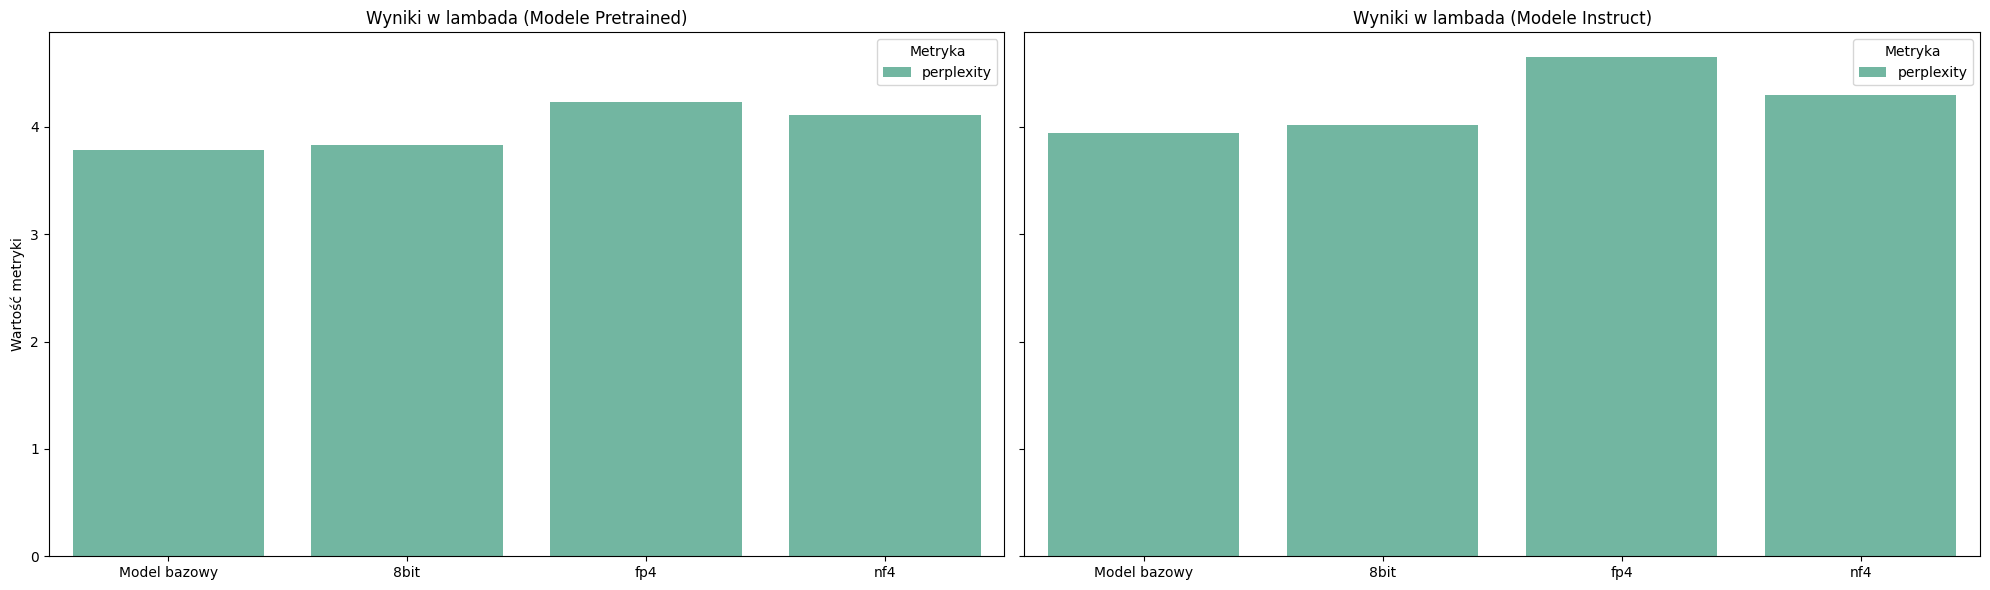

/tmp/ipykernel_142227/2107869547.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].str.replace(
/tmp/ipykernel_142227/2107869547.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].apply(
/tmp/ipykernel_142227/2107869547.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

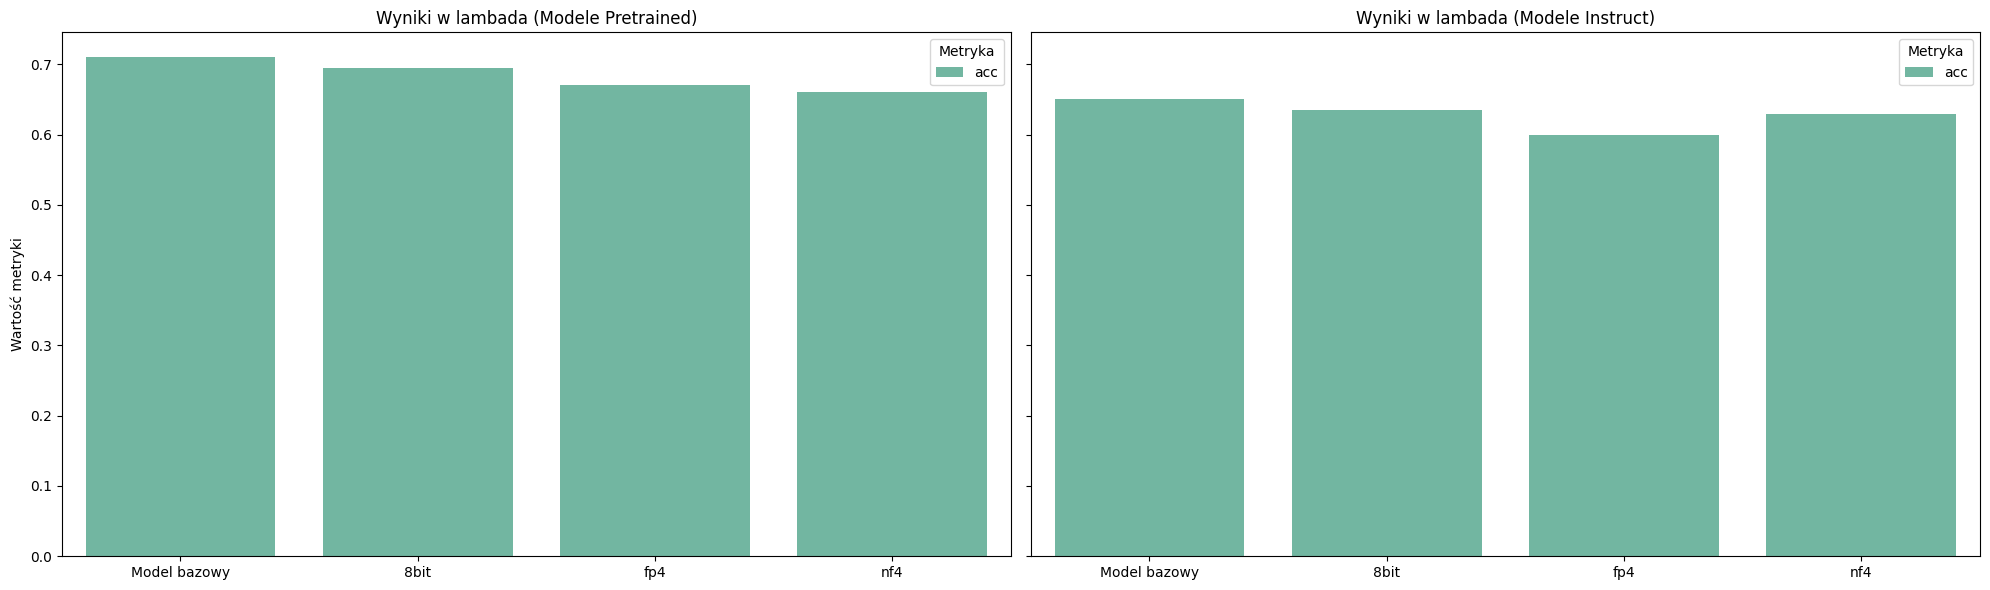

In [124]:
df_lambada = df.copy()
df_lambada["acc,none"].values[:] = 0
for dataset in dataset_names:
    if dataset == "lambada":
        plot_dataset(df_lambada, dataset)

df_lambada = df.copy()
df_lambada["perplexity,none"].values[:] = 0
for dataset in dataset_names:
    if dataset == "lambada":
        plot_dataset(df_lambada, dataset)

/tmp/ipykernel_142227/2107869547.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].str.replace(
/tmp/ipykernel_142227/2107869547.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].apply(
/tmp/ipykernel_142227/2107869547.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

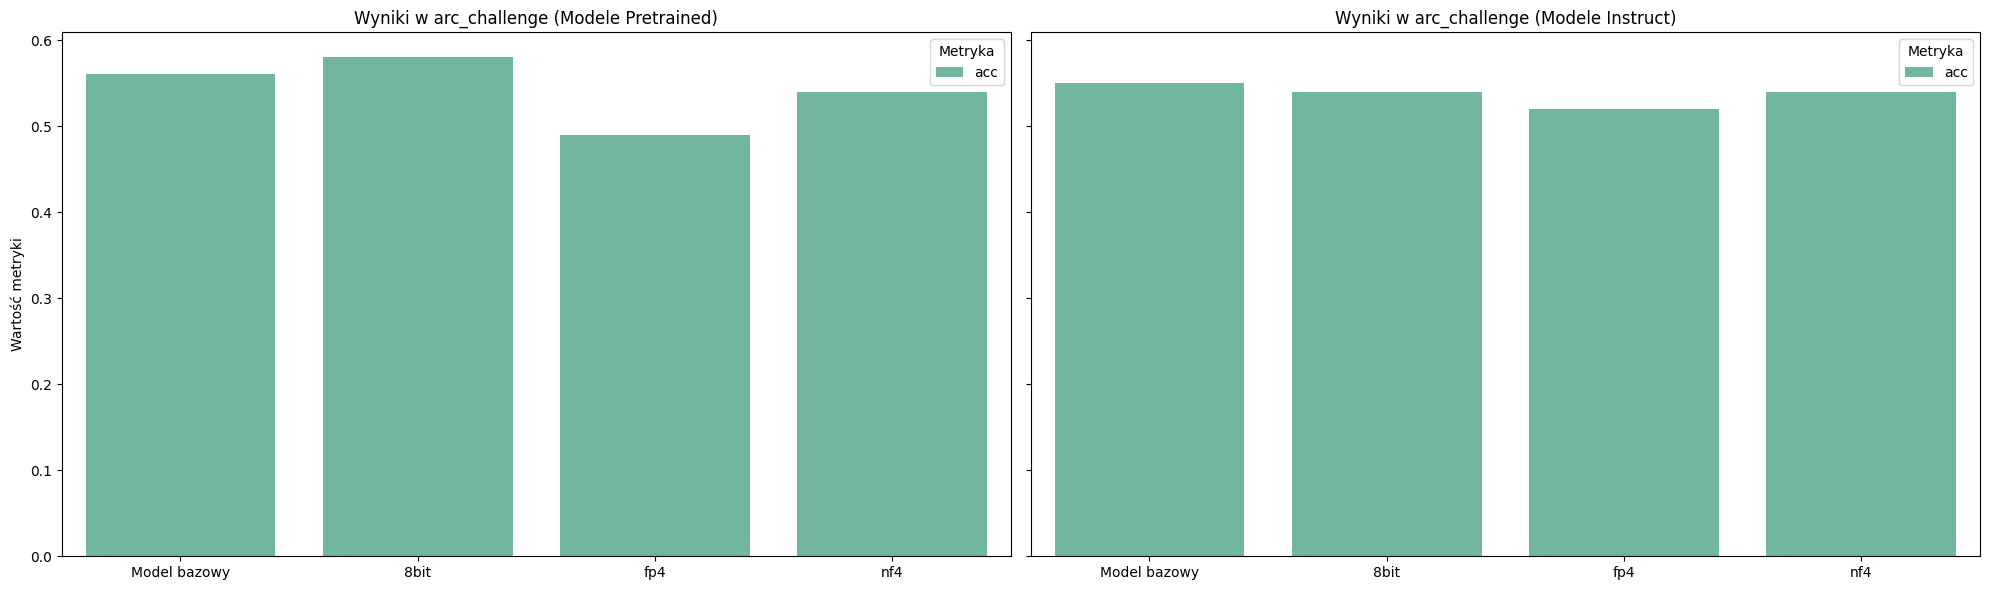

/tmp/ipykernel_142227/2107869547.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].str.replace(
/tmp/ipykernel_142227/2107869547.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].apply(
/tmp/ipykernel_142227/2107869547.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

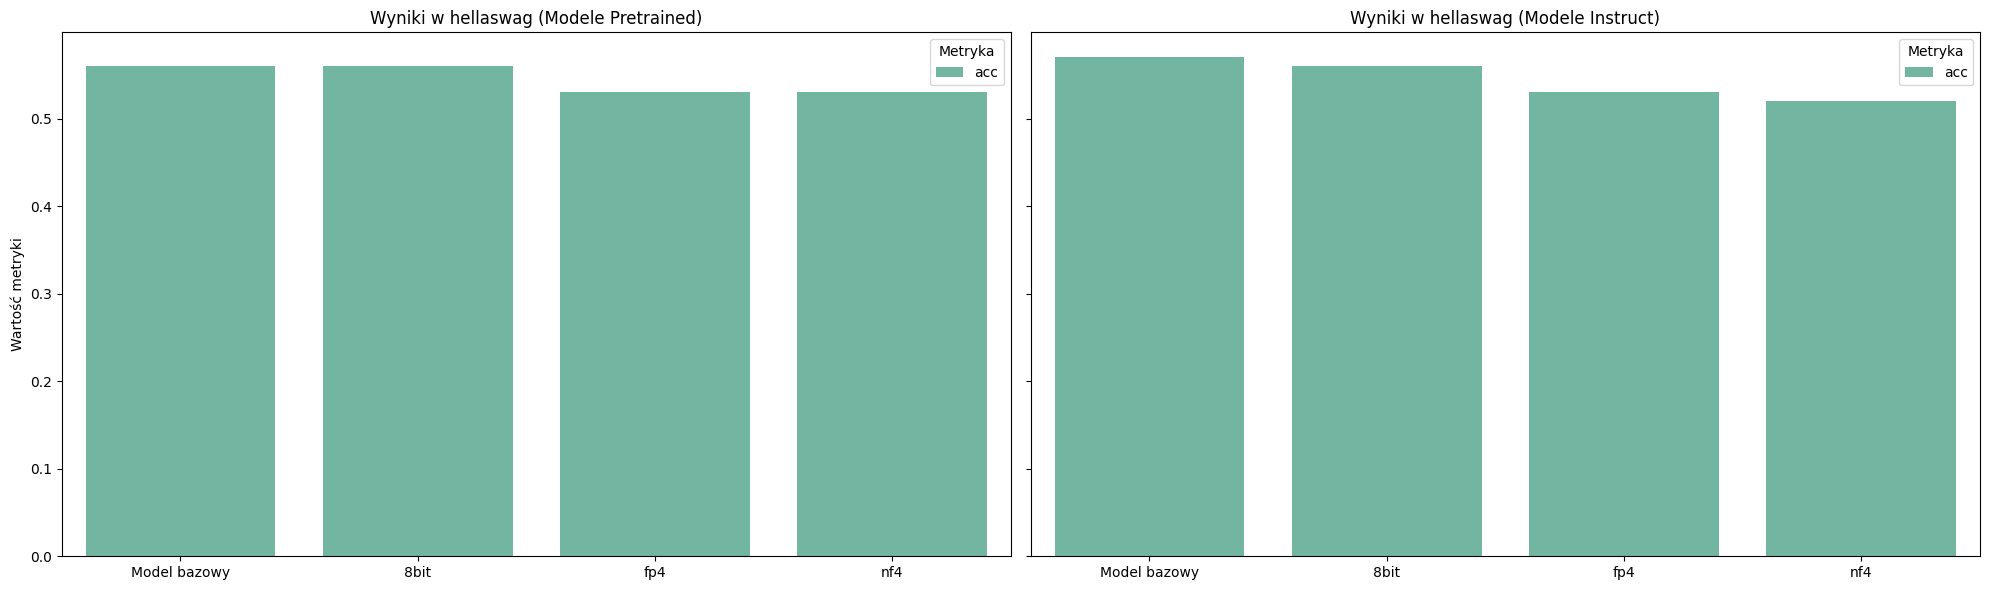

/tmp/ipykernel_142227/2107869547.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].str.replace(
/tmp/ipykernel_142227/2107869547.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].apply(
/tmp/ipykernel_142227/2107869547.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

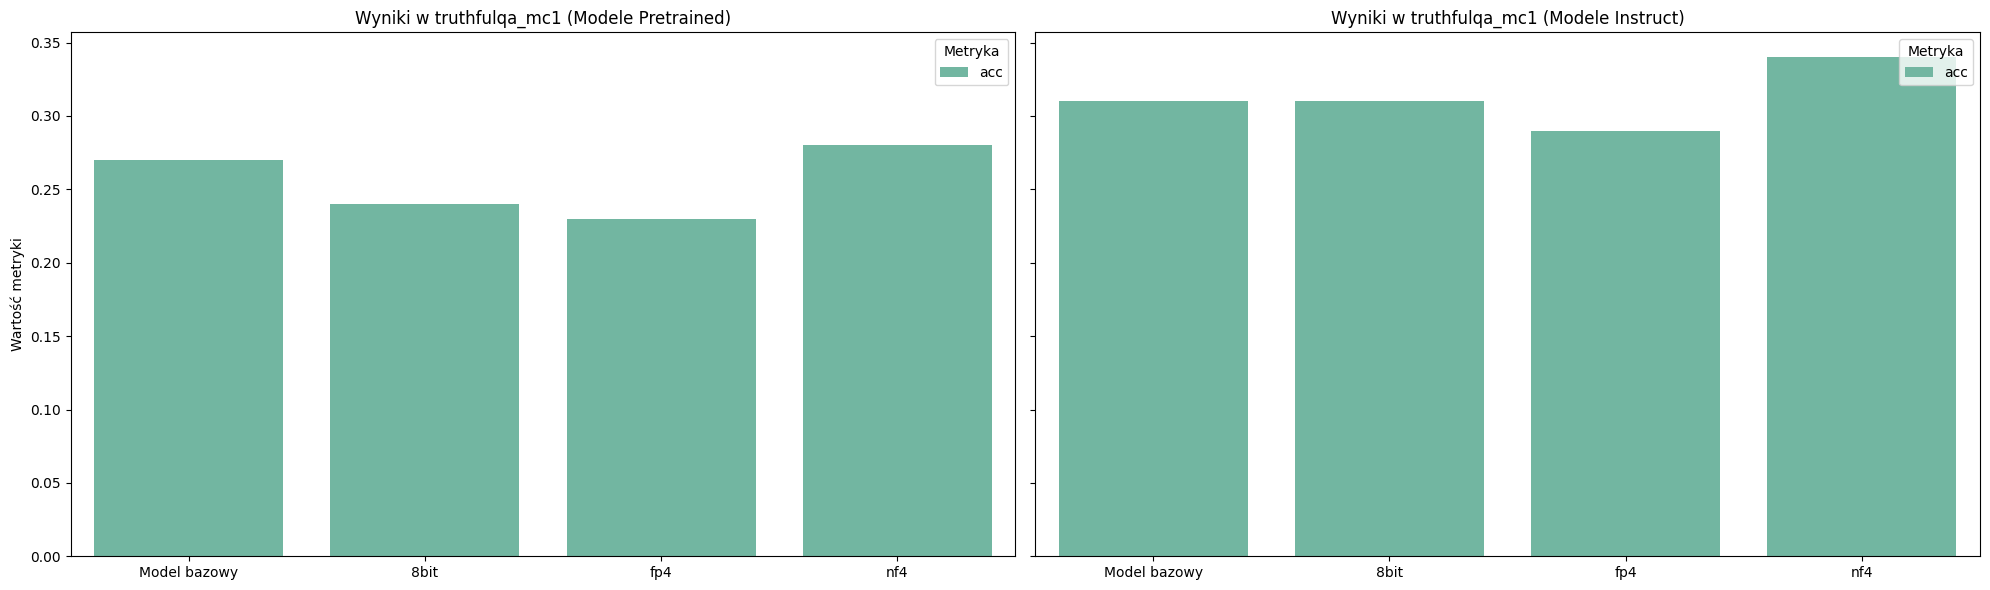

/tmp/ipykernel_142227/2107869547.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].str.replace(
/tmp/ipykernel_142227/2107869547.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].apply(
/tmp/ipykernel_142227/2107869547.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

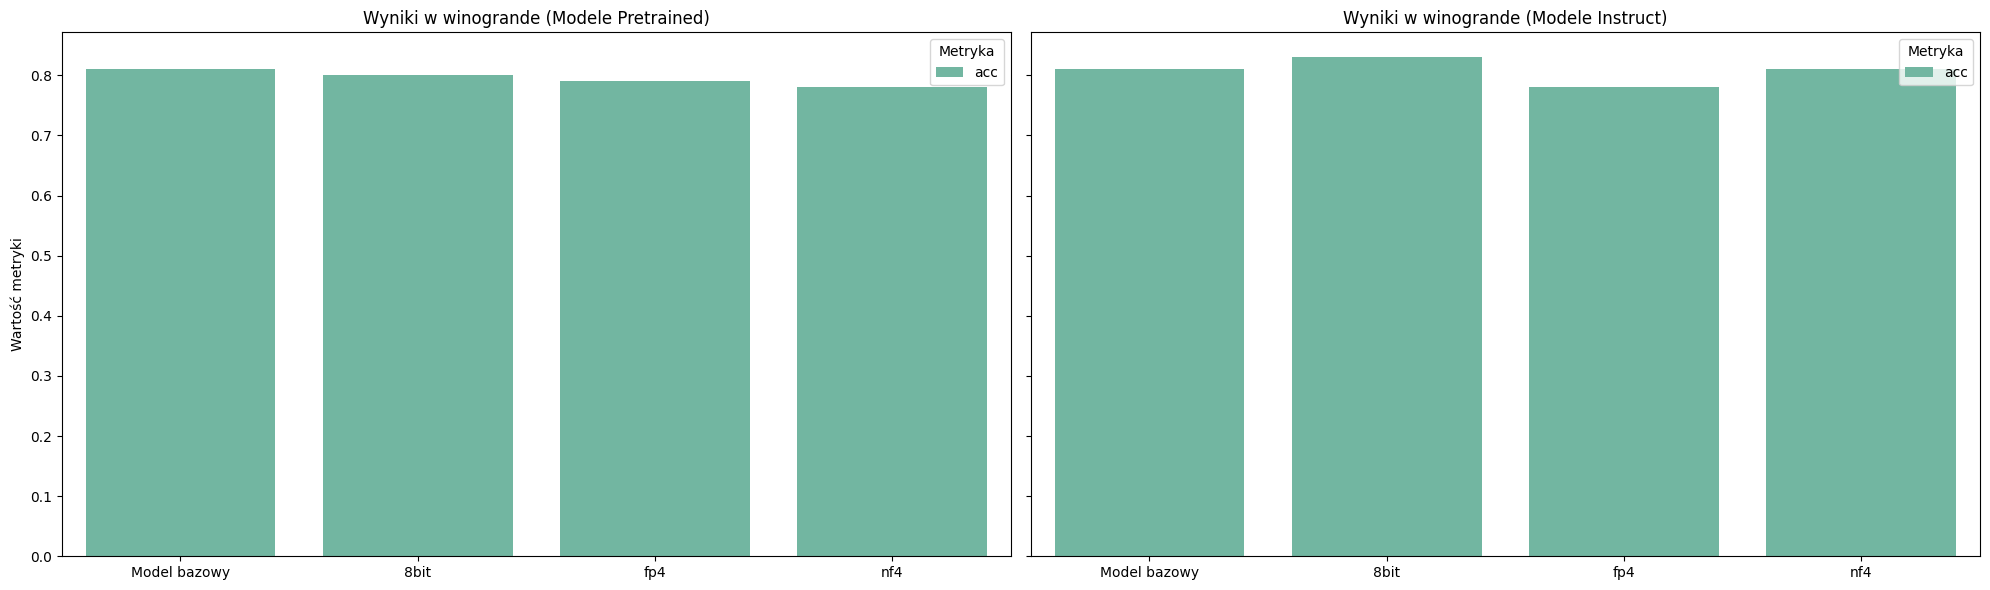

/tmp/ipykernel_142227/2107869547.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].str.replace(
/tmp/ipykernel_142227/2107869547.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].apply(
/tmp/ipykernel_142227/2107869547.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

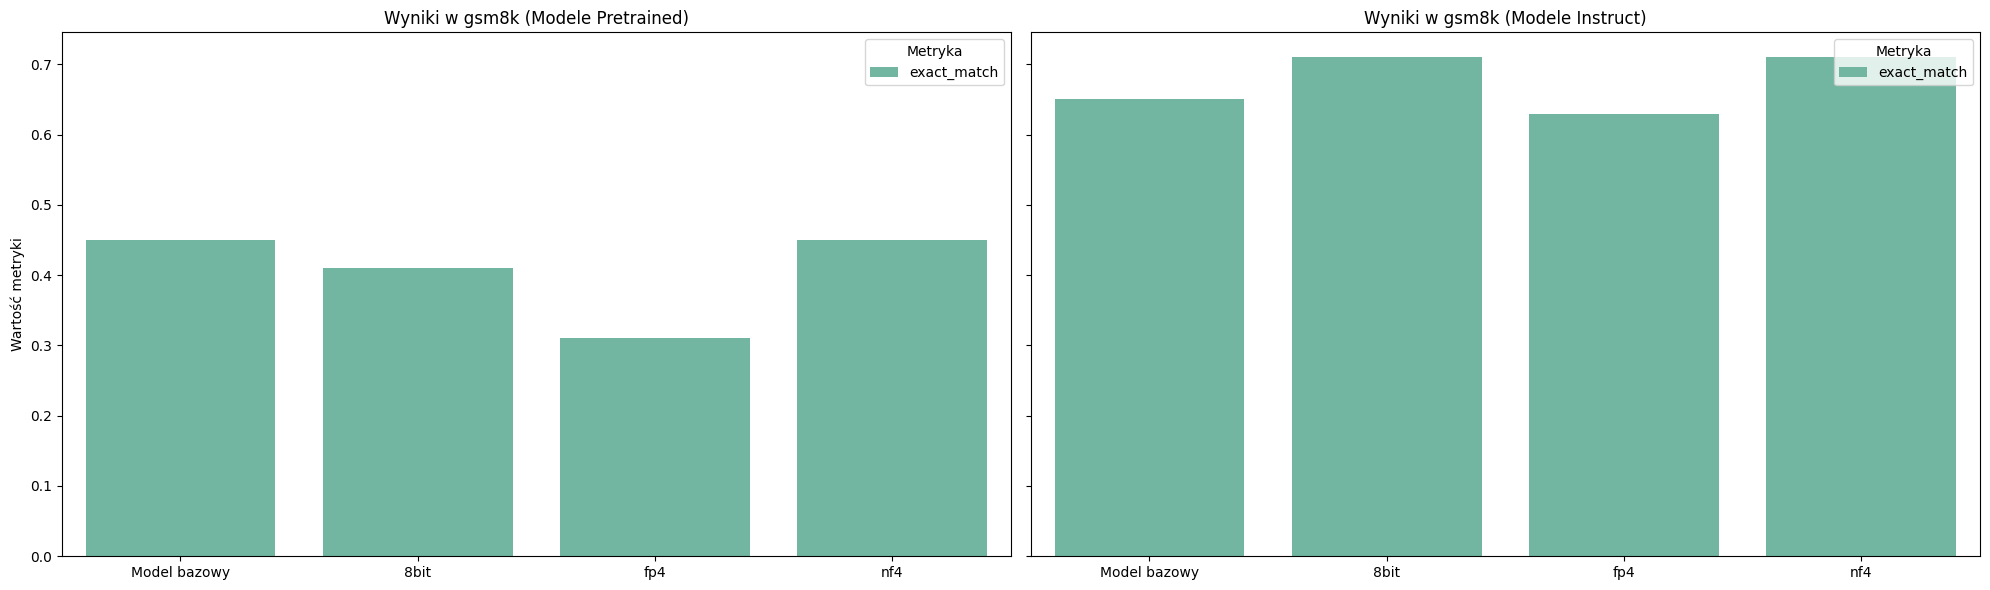

/tmp/ipykernel_142227/2107869547.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].str.replace(
/tmp/ipykernel_142227/2107869547.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].apply(
/tmp/ipykernel_142227/2107869547.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

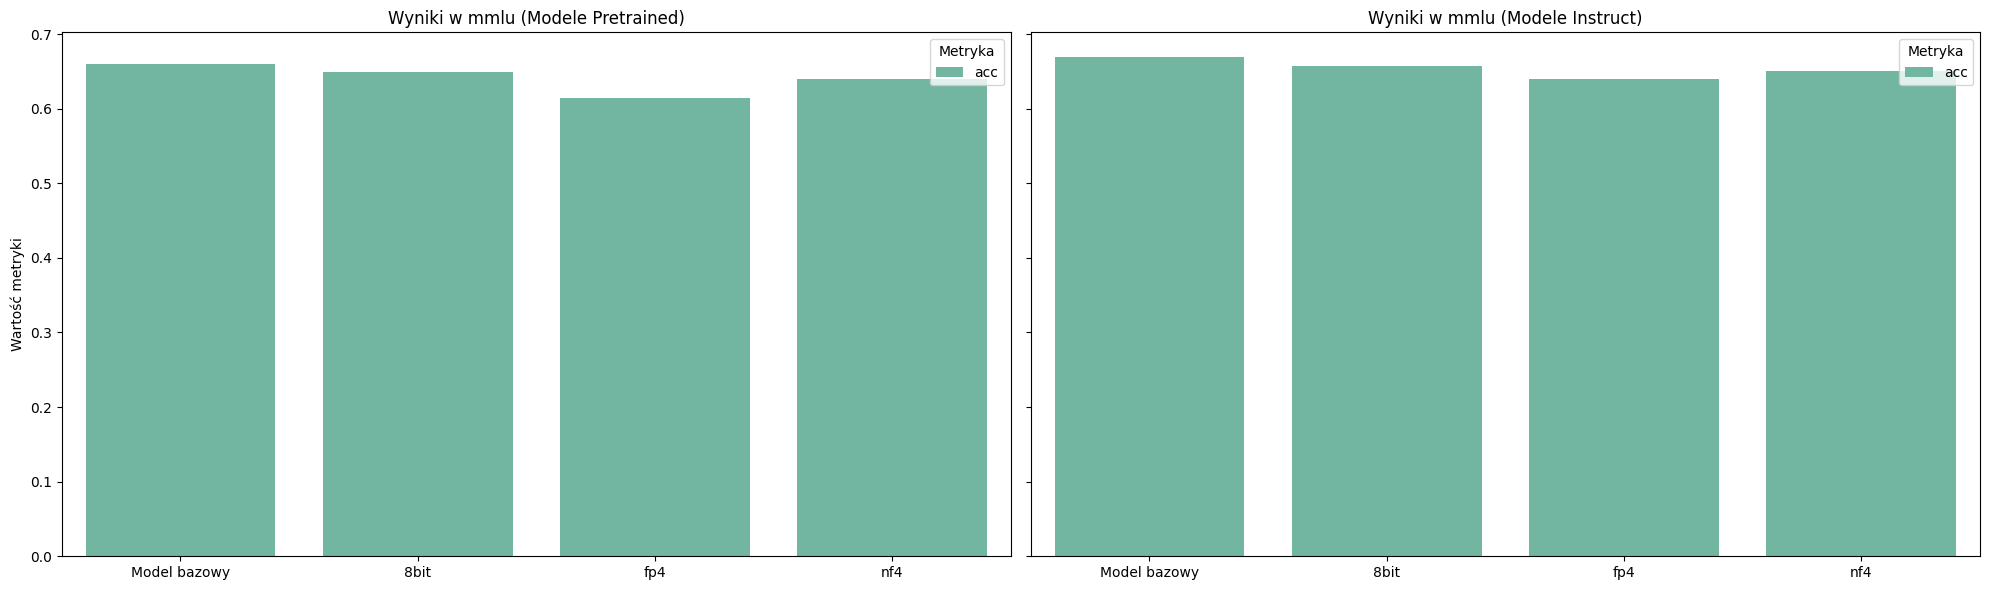

/tmp/ipykernel_142227/2107869547.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].str.replace(
/tmp/ipykernel_142227/2107869547.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].apply(
/tmp/ipykernel_142227/2107869547.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

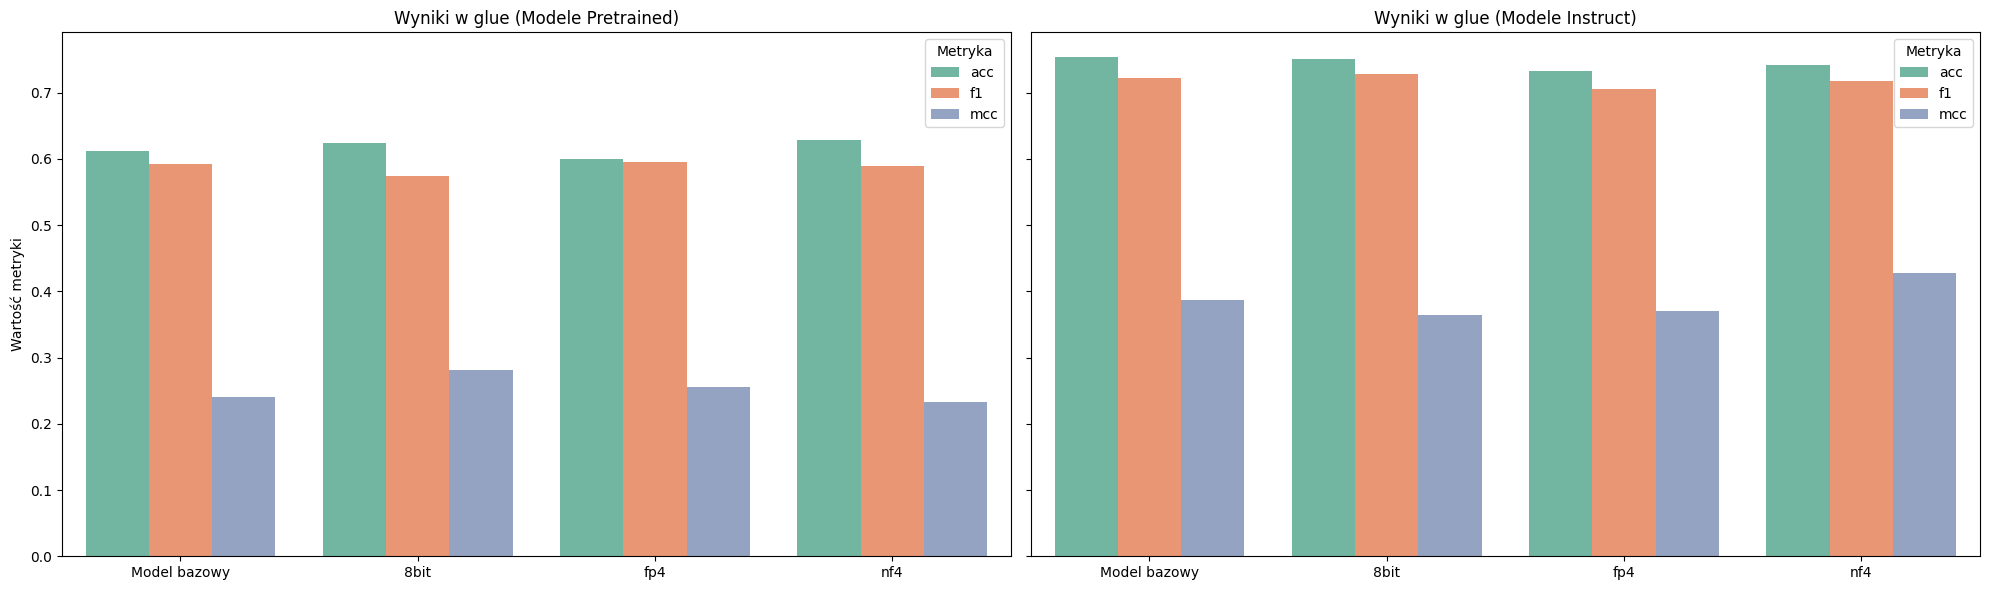

/tmp/ipykernel_142227/2107869547.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].str.replace(
/tmp/ipykernel_142227/2107869547.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].apply(
/tmp/ipykernel_142227/2107869547.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

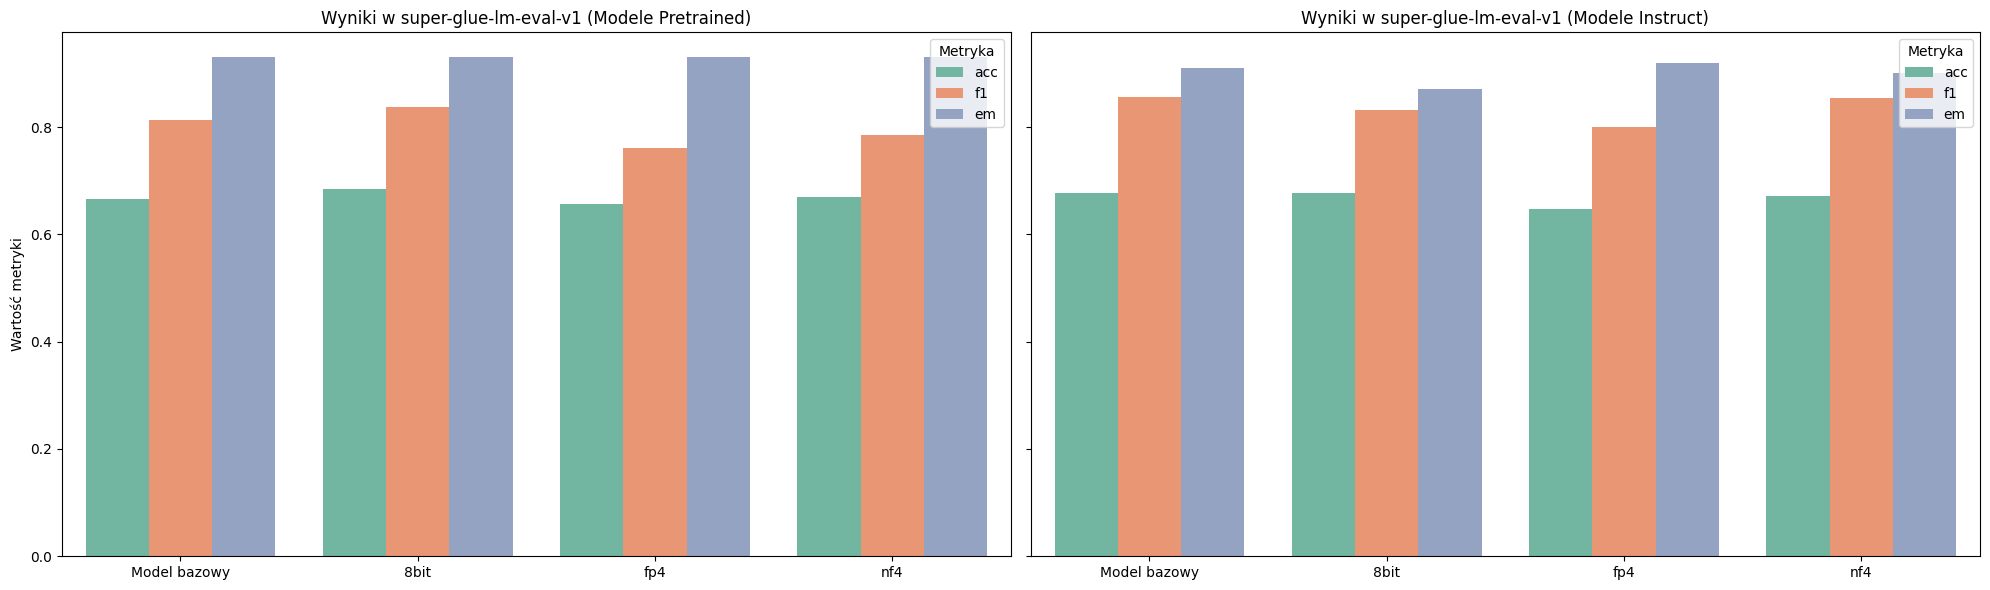

/tmp/ipykernel_142227/2107869547.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].str.replace(
/tmp/ipykernel_142227/2107869547.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pretrained_df["model"] = pretrained_df["model"].apply(
/tmp/ipykernel_142227/2107869547.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

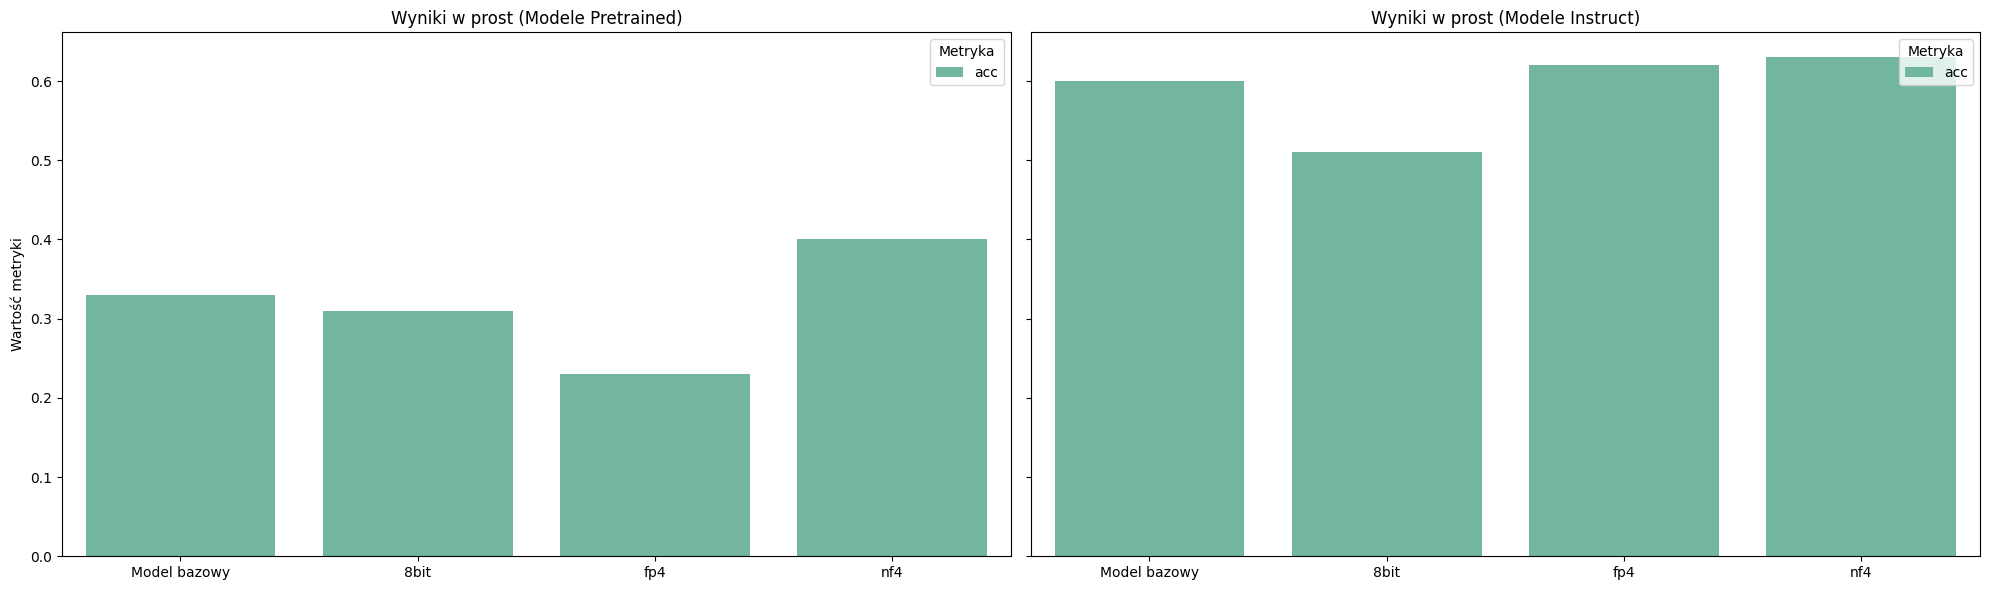

In [125]:
for dataset in dataset_names:
    if dataset != "lambada":
        plot_dataset(df, dataset)